In [105]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [56]:
# Step 2: Load the Dataset
# Load files
train_df = pd.read_csv('./data/train.csv', low_memory=False)
store_df = pd.read_csv('./data/store.csv', low_memory=False)

# Merge to get store features in training data
df = pd.merge(train_df, store_df, how='left', on='Store')

# View structure 
print(df.shape)

df.head()

(1017209, 18)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [50]:
# Data Preprocessing

# Drop closed days or zero sales
df = df[(df['Open'] == 1) & (df['Sales'] > 0)].copy()

# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Group by Date to get total daily sales
daily_sales = df.groupby('Date')['Sales'].sum()

# Sort by Date
df.sort_values("Date", inplace=True)

# Set Date as index
df.set_index("Date", inplace=True)


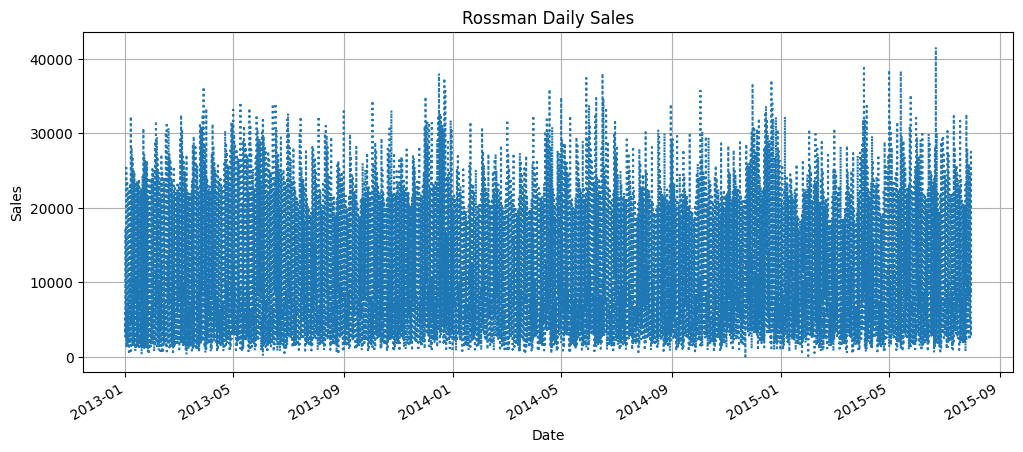

In [51]:
# Plot the Time Series

color_pal = sns.color_palette()

plt.figure(figsize=(12, 5))
df['Sales'].plot(style=':', ms=1, color=color_pal[0], title="Rossman Daily Sales")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Aggregate by day
daily_sales = df['Sales'].resample('D').sum()

# Drop missing days
daily_sales = daily_sales.asfreq('D')
daily_sales = daily_sales.asfreq('D').ffill()

# print(daily_sales.isna().sum())

# Decompose
result = seasonal_decompose(daily_sales, model='multiplicative', period=365)

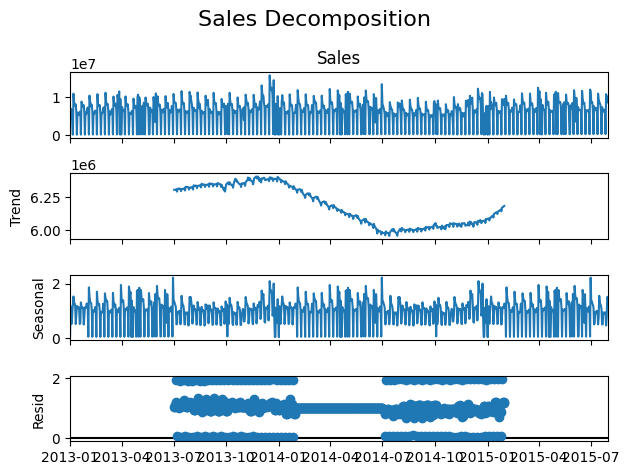

In [53]:
# Plot the decomposition
result.plot()
plt.suptitle("Sales Decomposition", fontsize=16)
plt.tight_layout()
plt.show()

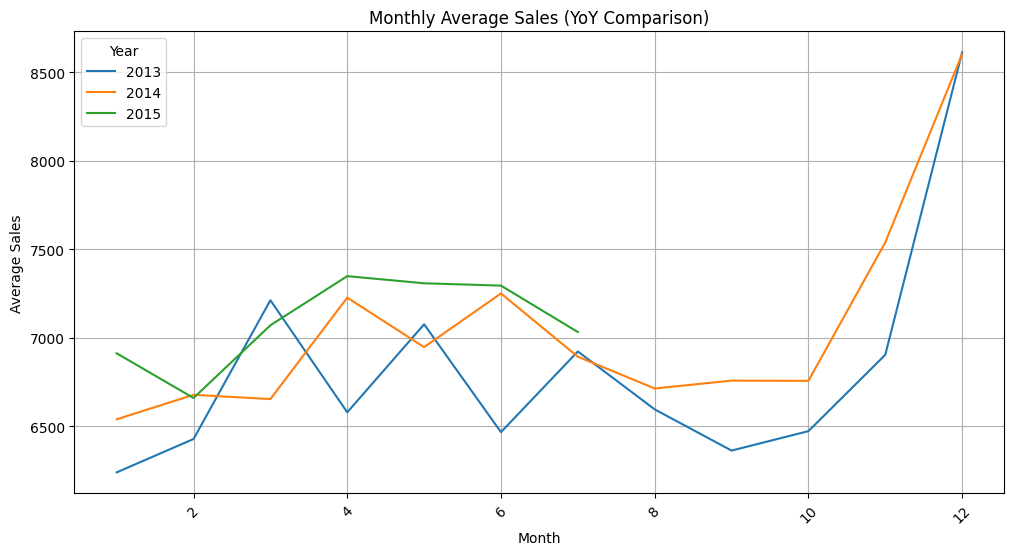

In [54]:
# Compare Year-over-Year (YoY)
from pandas import DatetimeIndex

# Assert index type (helps PyLance infer correctly)
assert isinstance(df.index, DatetimeIndex), "Index must be DateTimeIndex"
# Create a new column for Year and Month
df['Year'] = df.index.year
df['Month'] = df.index.month

# Monthly average sales
monthly_avg = df.groupby(['Year', 'Month'])['Sales'].mean().unstack(0)

monthly_avg.plot(figsize=(12,6), title="Monthly Average Sales (YoY Comparison)")
plt.ylabel("Average Sales")
plt.xlabel("Month")
plt.xticks(rotation=45) 
plt.grid(True)
plt.show()

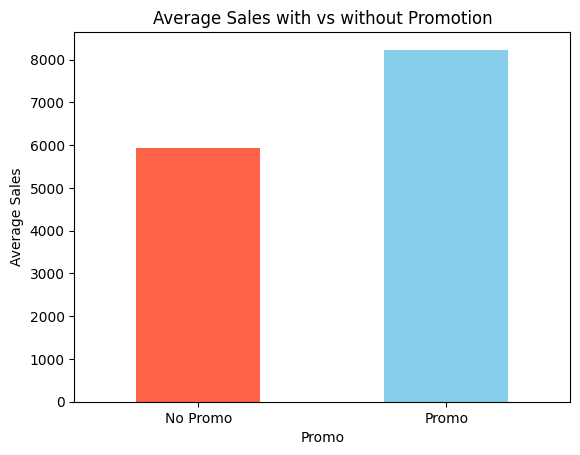

In [55]:
# Check effect of Promo
promo_avg = df.groupby(['Promo'])['Sales'].mean()

promo_avg.plot(kind='bar', title='Average Sales with vs without Promotion', color=['tomato', 'skyblue'])
plt.ylabel("Average Sales")
plt.xticks([0, 1], ['No Promo', 'Promo'], rotation=0)
plt.show()


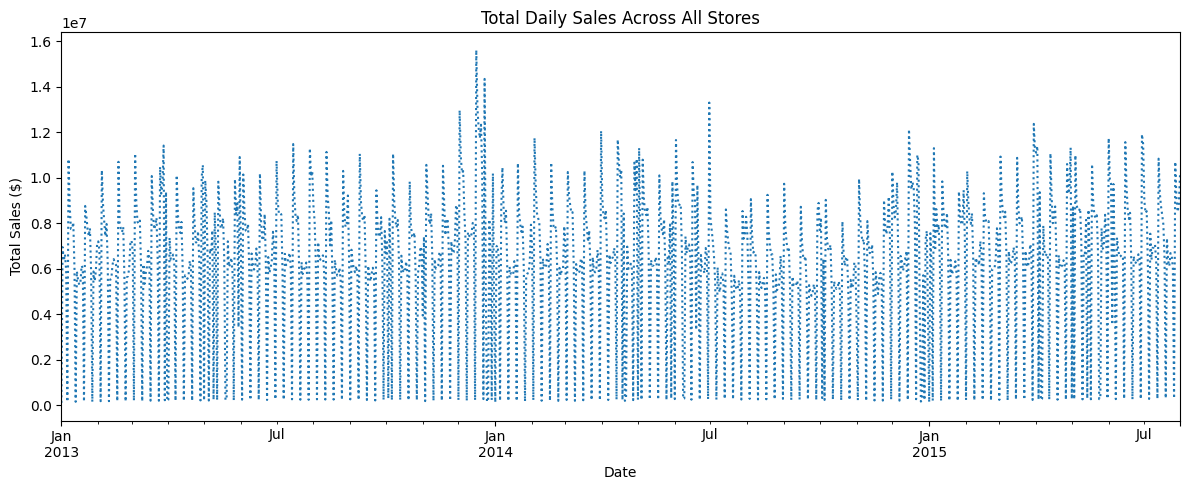

In [141]:
# Plot total daily sales across all stores to visualize demand over time:

color_pal = sns.color_palette()
daily_sales.plot(
    style=':',
    figsize=(12, 5),
    ms=3,
    color=color_pal[0],
    title='Total Daily Sales Across All Stores'
)
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.tight_layout()
plt.show()

In [132]:
# Let's model Store 2 
store_id = 2
store_df = df[df['Store'] == store_id][['Date', 'Sales']].copy()

# Rename for Prophet
store_df.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)


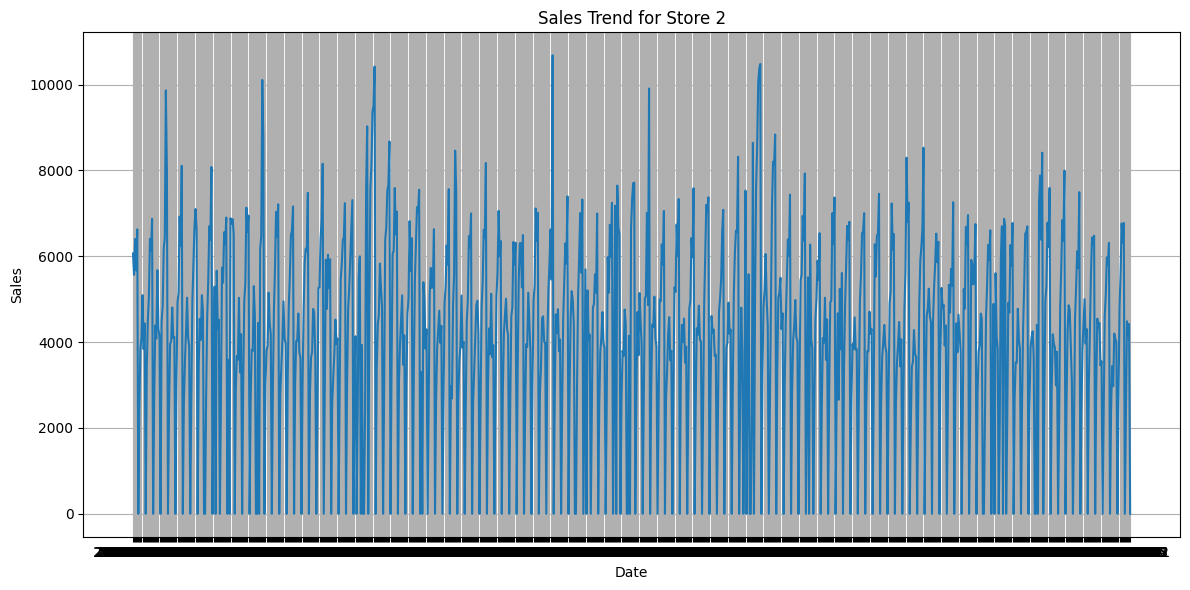

In [133]:
# Visualize the sales Trend for Selected Store

plt.figure(figsize=(12, 6))
plt.plot(store_df['ds'], store_df['y'])
plt.title(f"Sales Trend for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()


00:30:27 - cmdstanpy - INFO - Chain [1] start processing
00:30:27 - cmdstanpy - INFO - Chain [1] done processing


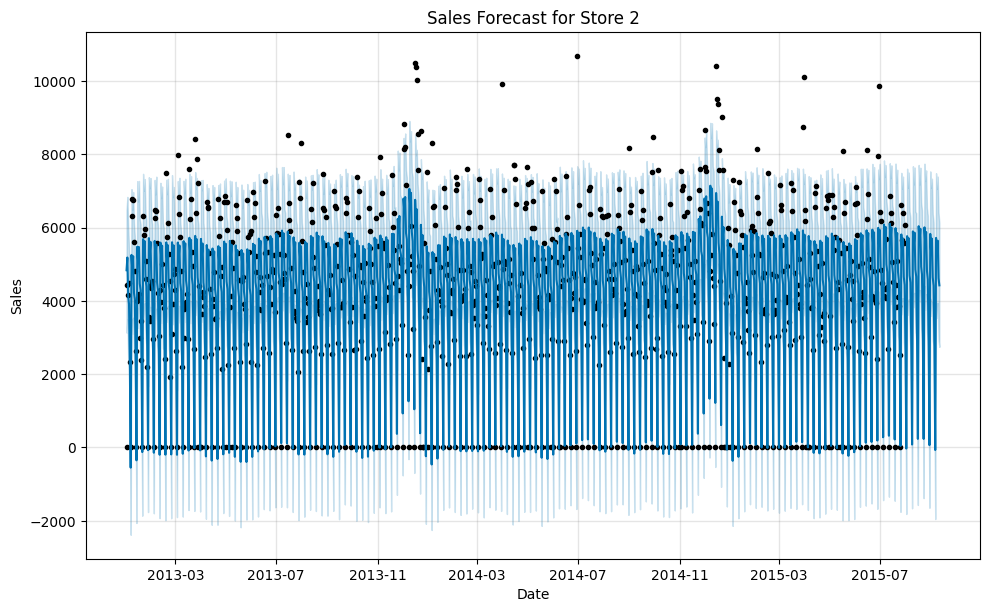

In [135]:
from prophet import Prophet
import matplotlib.pyplot as plt

# 1. Filter sales for this store
store_id = 2  # or loop through store_ids
store_sales_df = train_df[train_df['Store'] == store_id][['Date', 'Sales']]

# 2. Rename for Prophet
store_sales_df = store_sales_df.rename(columns={'Date': 'ds', 'Sales': 'y'})

# 3. Fit Prophet
model = Prophet()
model.fit(store_sales_df)

# 4. Forecast
future = model.make_future_dataframe(periods=42)
forecast = model.predict(future)

# 5. Plot
model.plot(forecast)
plt.title(f"Sales Forecast for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()



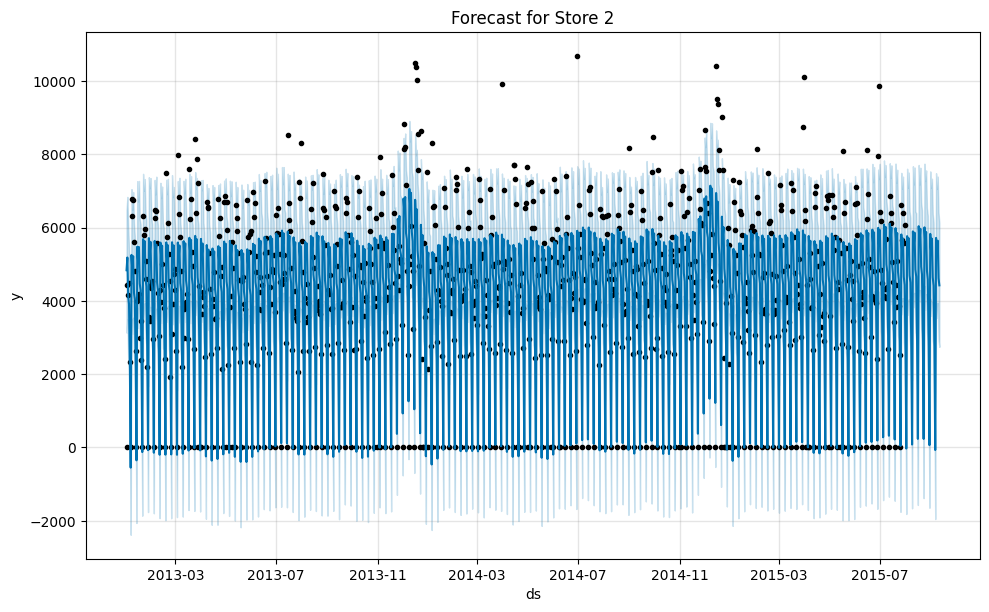

In [136]:
# Plot forecast components
model.plot(forecast)
plt.title(f"Forecast for Store {store_id}")
plt.show()


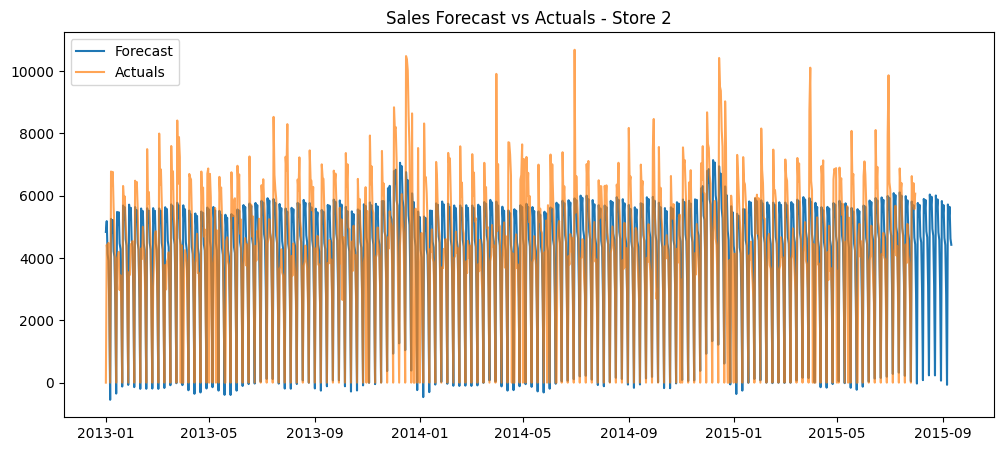

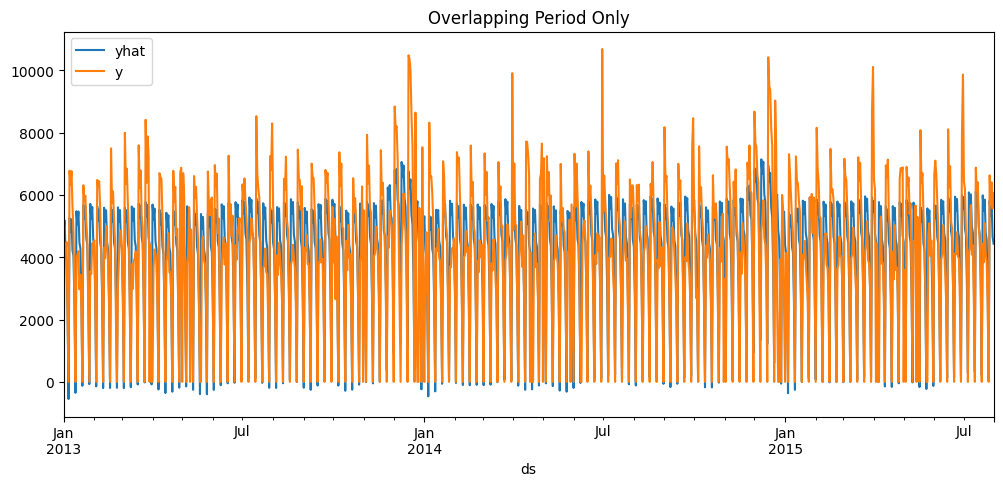

In [137]:
# Overlay with Actual (Train/Test)
# Merge forecast with actuals

# Ensure both date columns are datetime
forecast['ds'] = pd.to_datetime(forecast['ds'])
store_sales_df['ds'] = pd.to_datetime(store_sales_df['ds'])

# Now merge and sort
plot_df = forecast.set_index('ds')[['yhat']].join(
    store_sales_df.set_index('ds')[['y']],
    how='outer'
).sort_index()

# Plot available data
plt.figure(figsize=(12, 5))
plt.plot(plot_df.index, plot_df['yhat'], label='Forecast')
plt.plot(plot_df.index, plot_df['y'], label='Actuals', alpha=0.7)
plt.title(f"Sales Forecast vs Actuals - Store {store_id}")
plt.legend()
plt.show()

# Or plot only overlapping period
overlap_df = plot_df.dropna()
if not overlap_df.empty:
    overlap_df.plot(figsize=(12, 5), title="Overlapping Period Only")

In [138]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-01,4020.117290,3133.727694,6470.689860,4020.117290,4020.117290,816.313663,816.313663,816.313663,1211.852742,1211.852742,1211.852742,-395.539079,-395.539079,-395.539079,0.0,0.0,0.0,4836.430953
1,2013-01-02,4020.372681,3493.558187,6836.798884,4020.372681,4020.372681,1162.074460,1162.074460,1162.074460,1587.347870,1587.347870,1587.347870,-425.273410,-425.273410,-425.273410,0.0,0.0,0.0,5182.447141
2,2013-01-03,4020.628071,2421.384436,6012.361153,4020.628071,4020.628071,109.414756,109.414756,109.414756,554.714124,554.714124,554.714124,-445.299367,-445.299367,-445.299367,0.0,0.0,0.0,4130.042827
3,2013-01-04,4020.883462,2169.310533,5432.439526,4020.883462,4020.883462,-112.797247,-112.797247,-112.797247,343.156829,343.156829,343.156829,-455.954076,-455.954076,-455.954076,0.0,0.0,0.0,3908.086215
4,2013-01-05,4021.138852,510.359226,4091.055060,4021.138852,4021.138852,-1704.280589,-1704.280589,-1704.280589,-1246.534697,-1246.534697,-1246.534697,-457.745892,-457.745892,-457.745892,0.0,0.0,0.0,2316.858263


In [139]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Drop NaNs
df_eval = forecast[['ds', 'yhat']].merge(store_sales_df[['ds', 'y']], on='ds').dropna()

# RMSE (unchanged)
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
print(f'📉 RMSE: {rmse:.2f}')

# SMAPE (safe for zeros)
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))  # +1e-8 avoids division by zero

smape_score = smape(df_eval['y'], df_eval['yhat'])
print(f'📊 SMAPE: {smape_score:.2f}%')

📉 RMSE: 1351.54
📊 SMAPE: 48.91%


In [142]:
# Feature Engineering and Visualization in time series analysis to understand weekday effects.

from pandas.api.types import CategoricalDtype

# Define categorical weekday order
cat_type = CategoricalDtype(categories=['Monday','Tuesday','Wednesday','Thursday','Friday'],
                            ordered=True)

# Feature generation function
def create_features(df, label=None):
    """
    Creates time series features from datetime column.
    """
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index('Date')  # Make Date the index

    df['dayofweek'] = df.index.dayofweek
    df['weekday'] = df.index.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Approximate season (works for northern hemisphere)
    df['date_offset'] = (df.index.month * 100 + df.index.day - 320) % 1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = df[['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]
    if label:
        y = df[label]
        return X, y
    return X


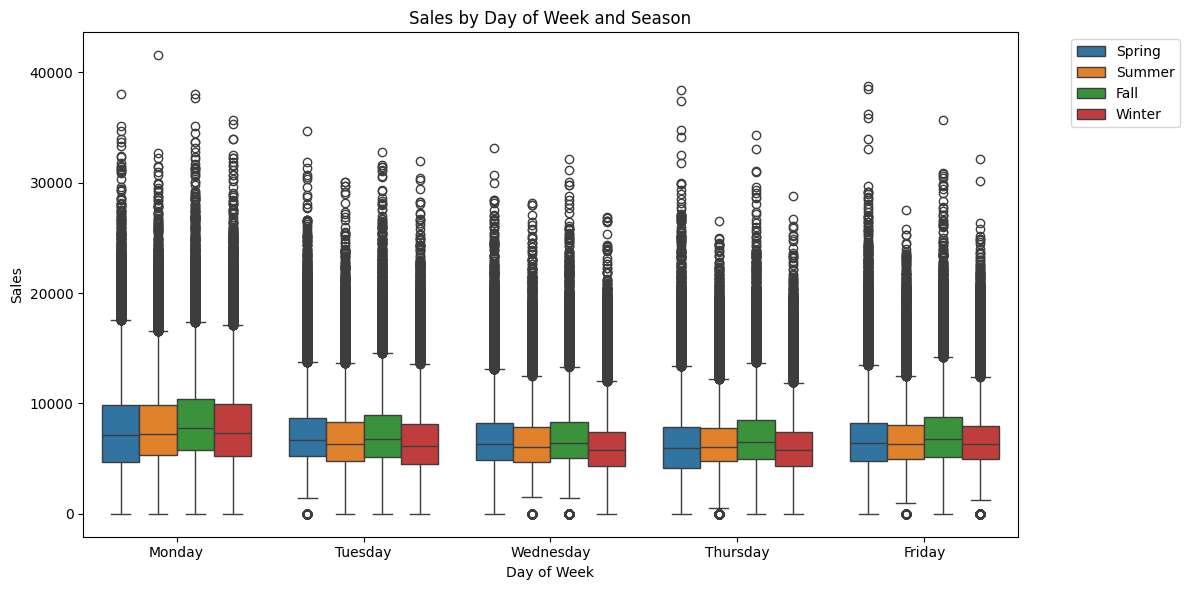

In [143]:
# Create features and target variables

X, y = create_features(df, label='Sales')
features_and_target = pd.concat([X, y], axis=1) # type: ignore

# Plot: Sales distribution across weekdays and seasons
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='Sales',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Sales by Day of Week and Season')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Sales')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


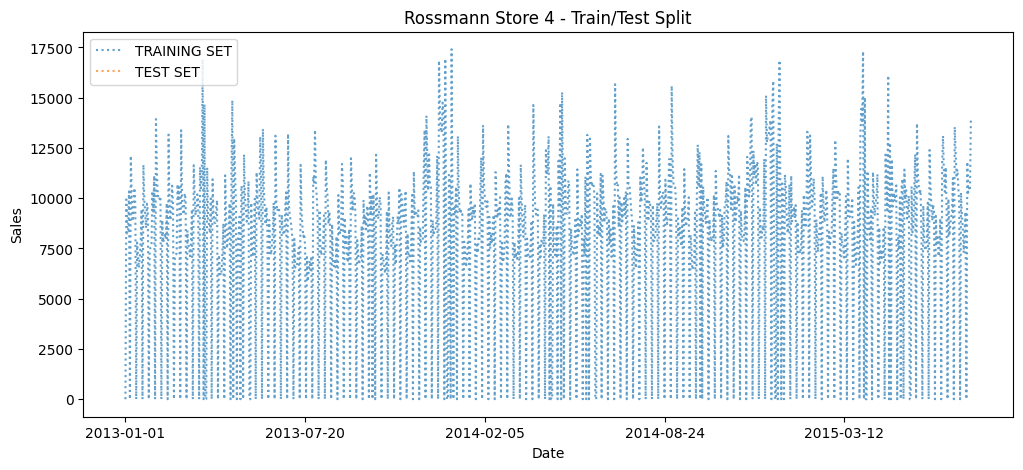

In [85]:
# Load data (assuming train_df is loaded similarly)
test_df = pd.read_csv('./data/test.csv', low_memory=False)
test_df = test_df.merge(store_df, on='Store', how='left')

# Filter for Store 4
store_id = 4
train_store = train_df[train_df['Store'] == store_id].set_index('Date')[['Sales']].rename(columns={'Sales': 'TRAINING SET'})
test_store = test_df[test_df['Store'] == store_id].set_index('Date')
test_store['TEST SET'] = 0  # Dummy column for plotting

# Combine for plotting
combined = train_store.join(test_store[['TEST SET']], how='outer')

# Plot
combined.plot(figsize=(12, 5), style=':', ms=1, alpha=0.7)
plt.xlabel("Date")
plt.ylabel("Sales")

# Highlight test period if it exists
if not test_store.empty:
    plt.axvspan(test_store.index.min(), test_store.index.max(), color='orange', alpha=0.3, label="TEST PERIOD")

plt.title(f"Rossmann Store {store_id} - Train/Test Split")
plt.legend()
plt.show()

00:42:16 - cmdstanpy - INFO - Chain [1] start processing
00:42:16 - cmdstanpy - INFO - Chain [1] done processing


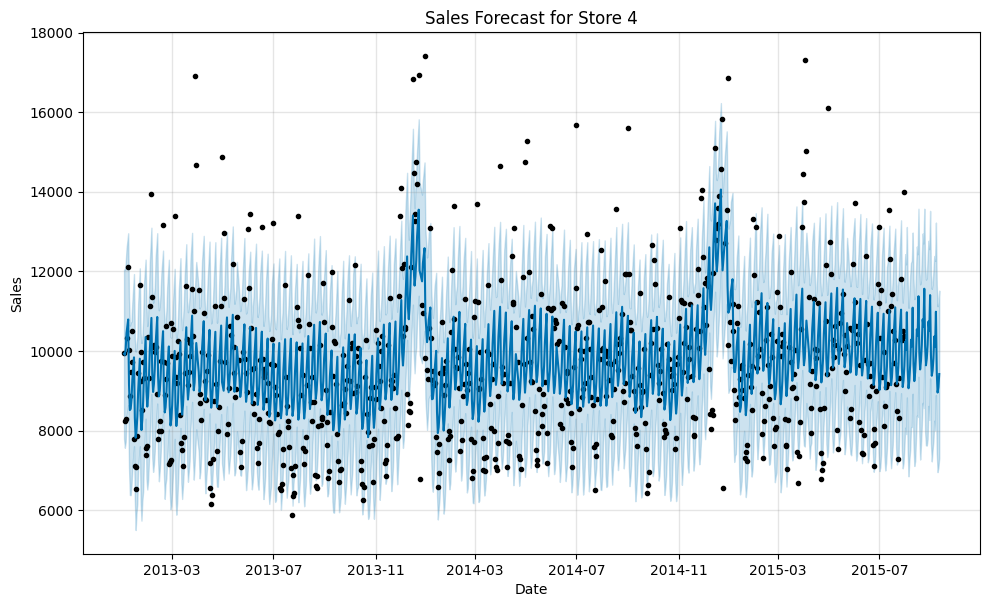

In [150]:
# Prepare data for Prophet

# Assume df is the full training dataset
store_id = 4

# 1. Filter for one store and exclude zero sales
df_prophet = df[(df['Store'] == store_id) & (df['Sales'] > 0)].copy()

# 2. Convert Date and rename columns
df_prophet['Date'] = pd.to_datetime(df_prophet['Date'])
df_prophet = df_prophet[['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Now df_prophet is ready for Prophet
model = Prophet(
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto'  # Or 'auto' if you want Prophet to decide
)
model.fit(df_prophet)
# Forecast next 6 weeks
future = model.make_future_dataframe(periods=42)
forecast = model.predict(future)

# Plot
model.plot(forecast)
plt.title(f"Sales Forecast for Store {store_id}")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

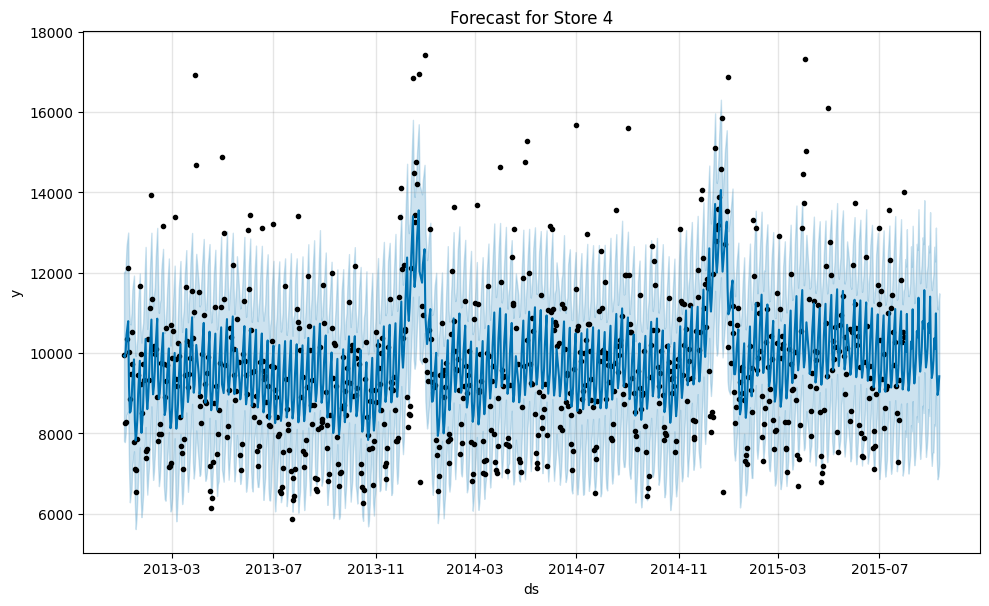

In [152]:
# Plot forecast components
model.plot(forecast)
plt.title(f"Forecast for Store {store_id}")
plt.show()


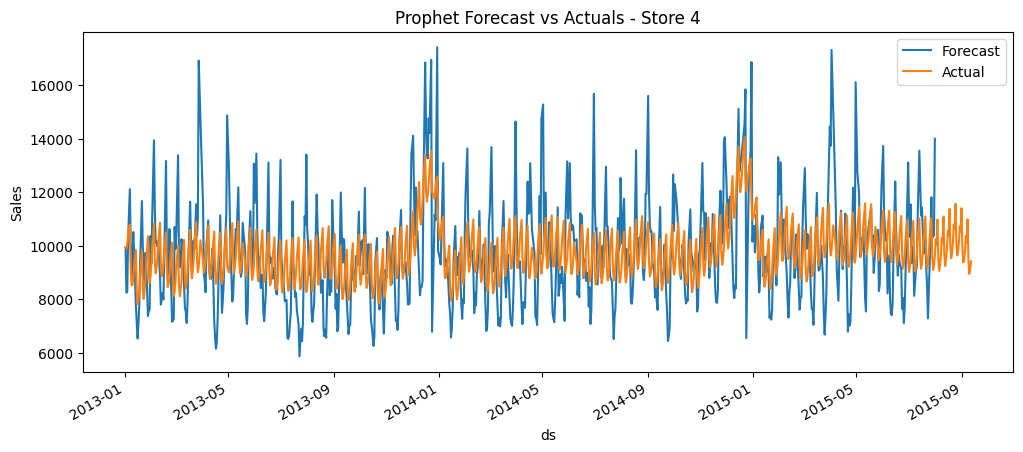

In [153]:
# Overlay with Actual (Train/Test)
# Merge forecast with actuals for comparison
forecast_df = forecast.set_index('ds')[['yhat']].join(
    df_prophet.set_index('ds')['y'], how='left'
)

forecast_df[['y', 'yhat']].plot(figsize=(12, 5), title=f"Prophet Forecast vs Actuals - Store {store_id}")
plt.legend(["Forecast", "Actual"])
plt.ylabel("Sales")
plt.show()


In [154]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Drop NaNs
df_eval = forecast[['ds', 'yhat']].merge(df_prophet[['ds', 'y']], on='ds').dropna()

# RMSE (unchanged)
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
print(f'📉 RMSE: {rmse:.2f}')

# SMAPE (safe for zeros)
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))  # +1e-8 avoids division by zero

smape_score = smape(df_eval['y'], df_eval['yhat'])
print(f'📊 SMAPE: {smape_score:.2f}%')

📉 RMSE: 1668.83
📊 SMAPE: 13.21%


In [151]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,9488.913168,7808.876820,12016.289602,9488.913168,9488.913168,443.836381,443.836381,443.836381,-754.135864,-754.135864,-754.135864,1197.972245,1197.972245,1197.972245,0.0,0.0,0.0,9932.749549
1,2013-01-03,9488.743555,7782.695475,12012.549033,9488.743555,9488.743555,410.617586,410.617586,410.617586,-567.308556,-567.308556,-567.308556,977.926141,977.926141,977.926141,0.0,0.0,0.0,9899.361141
2,2013-01-04,9488.573943,7991.607039,12146.598986,9488.573943,9488.573943,561.325023,561.325023,561.325023,-197.856221,-197.856221,-197.856221,759.181244,759.181244,759.181244,0.0,0.0,0.0,10049.898966
3,2013-01-05,9488.404330,8460.678833,12654.148568,9488.404330,9488.404330,961.408380,961.408380,961.408380,416.748282,416.748282,416.748282,544.660098,544.660098,544.660098,0.0,0.0,0.0,10449.812711
4,2013-01-07,9488.065105,8543.459944,12996.682049,9488.065105,9488.065105,1303.412468,1303.412468,1303.412468,1164.124717,1164.124717,1164.124717,139.287751,139.287751,139.287751,0.0,0.0,0.0,10791.477574


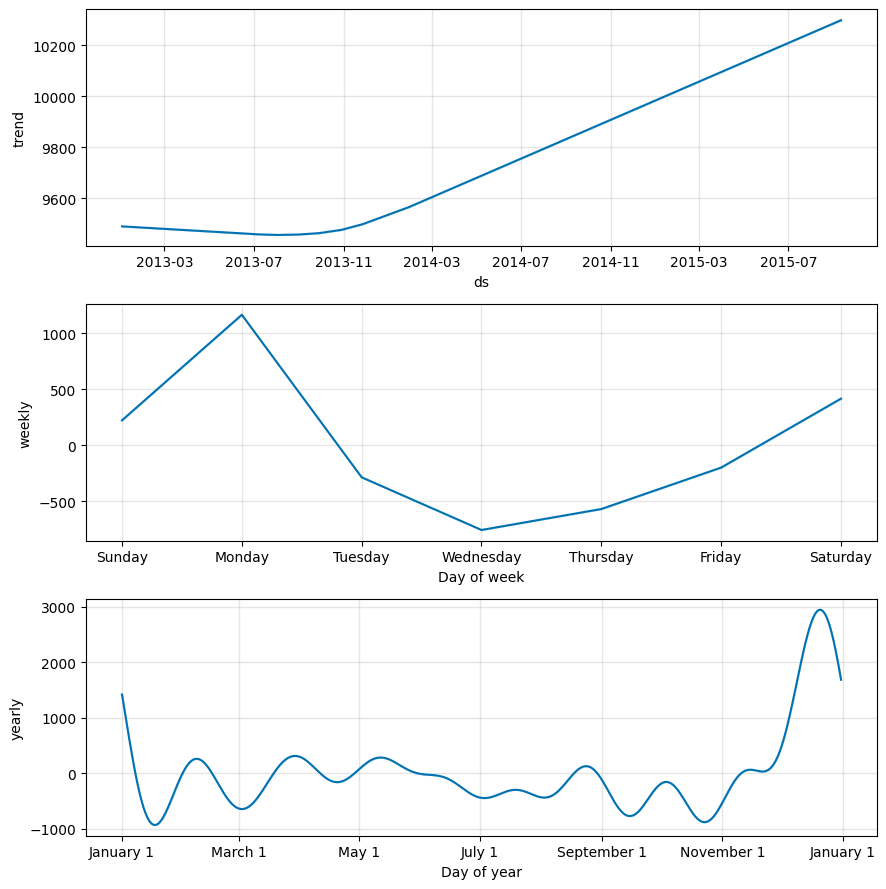

In [155]:
# Plot Forecast Components

model.plot_components(forecast)
plt.show()


In [169]:
from prophet import Prophet
from tqdm import tqdm

# Create a container for all forecasts
all_forecasts = []

# Get unique store IDs
store_ids = df['Store'].unique()

# Loop through each store
for store in tqdm(store_ids, desc="Processing stores"):

    # Filter data for the current store
    df_store = df[df['Store'] == store][['Date', 'Sales']].copy()
    
    # Rename for Prophet
    df_store = df_store.rename(columns={'Date': 'ds', 'Sales': 'y'})
    df_store['Store'] = store_id

    # Skip stores with too few data points
    if df_store.shape[0] < 100:
        continue

    # Initialize Prophet model
    model = Prophet(
       yearly_seasonality='auto',
       weekly_seasonality='auto',
       daily_seasonality='auto'  # Or 'auto' if you want Prophet to decide
    )
    
    # Fit the model
    model.fit(df_store)
    
    # Create future dataframe (e.g., 90 days)
    future = model.make_future_dataframe(periods=90)
    
    # Forecast
    forecast = model.predict(future)
    
    # Add store ID to forecast
    forecast['Store'] = store
    
    # Append to master list
    all_forecasts.append(forecast[['ds', 'yhat', 'Store']])

Processing stores:   0%|          | 0/1115 [00:00<?, ?it/s]

01:17:38 - cmdstanpy - INFO - Chain [1] start processing
01:17:39 - cmdstanpy - INFO - Chain [1] done processing
Processing stores:   0%|          | 1/1115 [00:00<12:23,  1.50it/s]01:17:39 - cmdstanpy - INFO - Chain [1] start processing
01:17:39 - cmdstanpy - INFO - Chain [1] done processing
Processing stores:   0%|          | 2/1115 [00:01<10:13,  1.81it/s]01:17:40 - cmdstanpy - INFO - Chain [1] start processing
01:17:40 - cmdstanpy - INFO - Chain [1] done processing
Processing stores:   0%|          | 3/1115 [00:01<12:05,  1.53it/s]01:17:40 - cmdstanpy - INFO - Chain [1] start processing
01:17:41 - cmdstanpy - INFO - Chain [1] done processing
Processing stores:   0%|          | 4/1115 [00:02<12:11,  1.52it/s]01:17:41 - cmdstanpy - INFO - Chain [1] start processing
01:17:41 - cmdstanpy - INFO - Chain [1] done processing
Processing stores:   0%|          | 5/1115 [00:03<10:42,  1.73it/s]01:17:41 - cmdstanpy - INFO - Chain [1] start processing
01:17:42 - cmdstanpy - INFO - Chain [1] don

In [170]:
# Combine all per-store forecasts
df_all_forecasts = pd.concat(all_forecasts, axis=0).reset_index(drop=True)


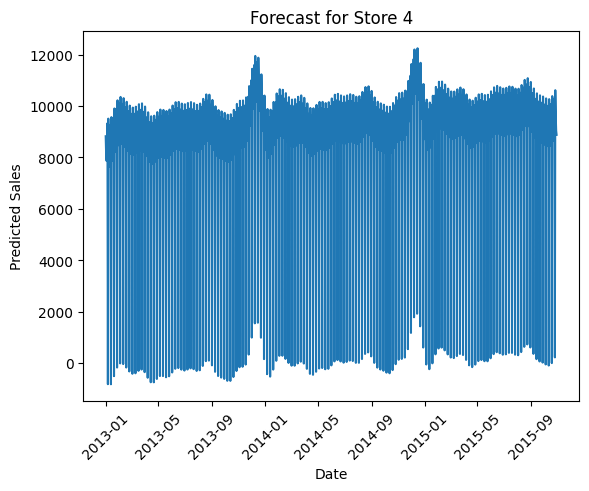

In [171]:
# Visualize Forecast for a Sample Store

import seaborn as sns
import matplotlib.pyplot as plt

# Plot sample forecast
sample_store = store_ids[3]
sample_forecast = df_all_forecasts[df_all_forecasts['Store'] == sample_store]

sns.lineplot(data=sample_forecast, x='ds', y='yhat')
plt.title(f'Forecast for Store {sample_store}')
plt.xlabel("Date")
plt.ylabel("Predicted Sales")
plt.xticks(rotation=45)
plt.show()


In [186]:
# Merge forecasts with actuals
df_store['ds'] = pd.to_datetime(df_store['ds'])
df_all_forecasts['ds'] = pd.to_datetime(df_all_forecasts['ds'])

df_eval = df_all_forecasts.merge(df_store, on=['Store', 'ds'])

# Drop any NaNs just in case
df_eval = df_eval.dropna(subset=['yhat', 'y'])



In [179]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Remove 0s and small values to avoid MAPE explosion
eval_df = forecast_df[forecast_df['y'] > 10].copy()

# Compute metrics
rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
mape = mean_absolute_percentage_error(eval_df['y'], eval_df['yhat'])

print(f"Store {store_id} - RMSE: {rmse:.2f}, MAPE: {mape:.4f}")



Store 4 - RMSE: 1668.83, MAPE: 0.1360


In [204]:
def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))


In [205]:
all_evals = []

for store_id in store_ids:
    store_df = df[df['Store'] == store_id][['Date', 'Sales']].copy()
    store_df.rename(columns={'Date': 'ds', 'Sales': 'y'}, inplace=True)
    store_df['ds'] = pd.to_datetime(store_df['ds'])

    store_forecast = df_all_forecasts[df_all_forecasts['Store'] == store_id][['ds', 'yhat']].copy()
    store_forecast['ds'] = pd.to_datetime(store_forecast['ds'])

    merged_df = store_forecast.merge(store_df, on='ds', how='left')
    eval_df = merged_df[merged_df['y'].notnull() & (merged_df['y'] != 0)]

    if not eval_df.empty:
        rmse = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
        mape = safe_mape(eval_df['y'], eval_df['yhat'])
        all_evals.append({'Store': store_id, 'RMSE': rmse, 'MAPE': mape})

results_df = pd.DataFrame(all_evals)
results_df_sorted = results_df.sort_values(by='MAPE')
print(results_df_sorted.head())



      Store         RMSE      MAPE
732     733  1494.891295  0.078635
1096   1097  1162.640059  0.082896
768     769  1202.968012  0.083675
759     760   938.800369  0.086395
103     104  1195.856052  0.089658


In [199]:
# Export to CSV
results_df_sorted.to_csv("store_forecast_metrics.csv", index=False)

# Export to Excel
results_df_sorted.to_excel("store_forecast_metrics.xlsx", index=False)


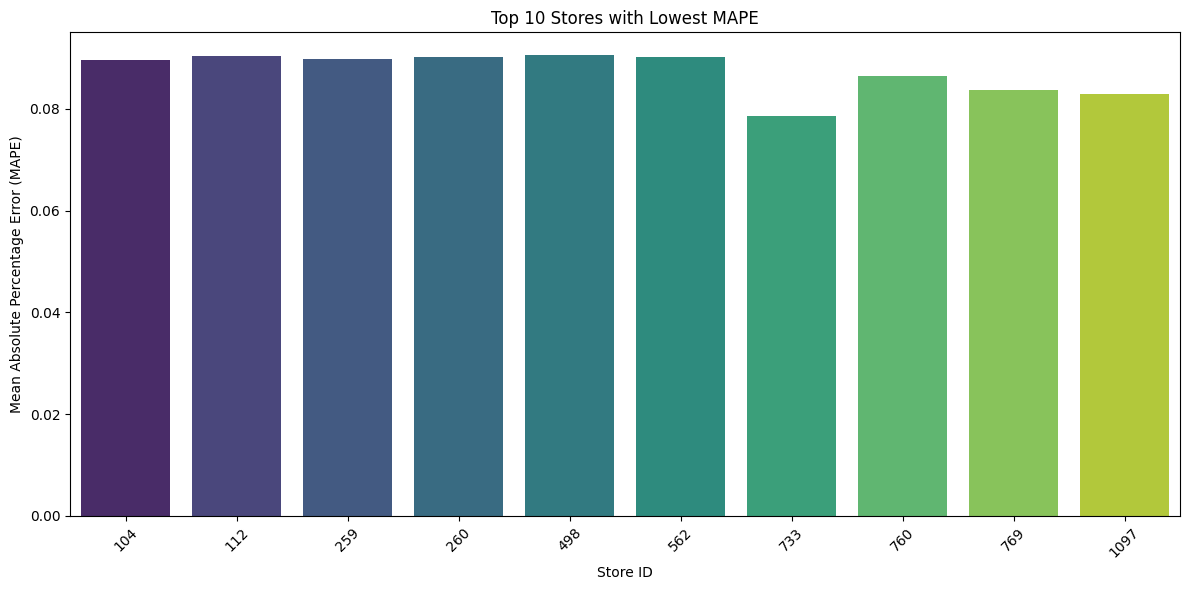

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 10 by lowest MAPE
top_10_stores = results_df_sorted.nsmallest(10, "MAPE")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_stores, x="Store", y="MAPE", palette="viridis")

plt.title("Top 10 Stores with Lowest MAPE")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.xlabel("Store ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


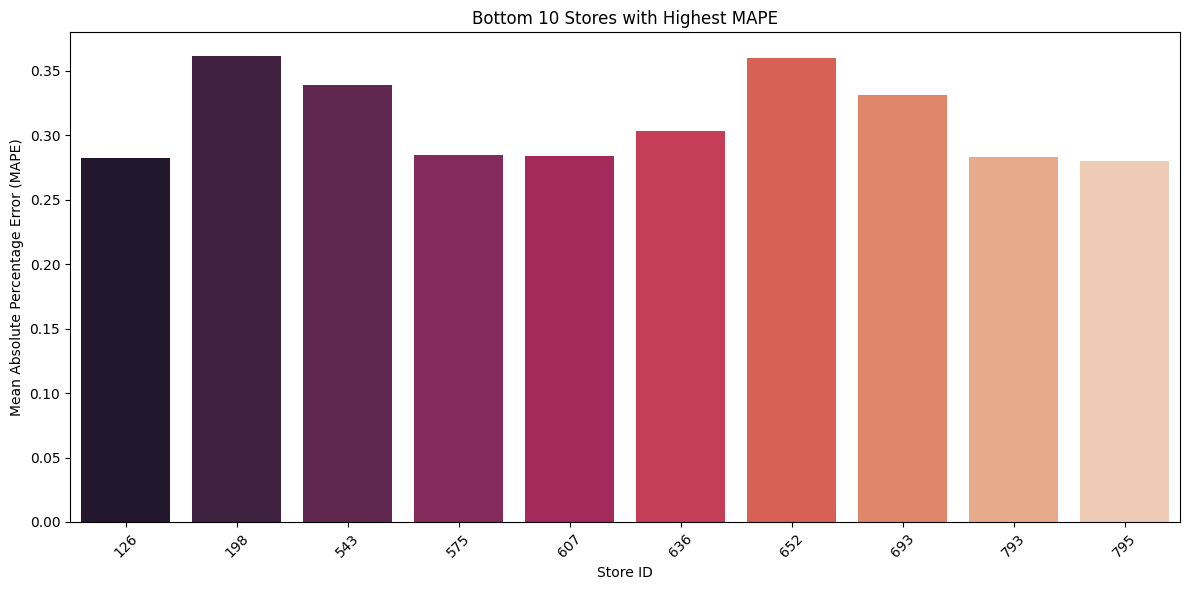

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select bottom 10 by highest MAPE
bottom_10_stores = results_df_sorted.nlargest(10, "MAPE")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=bottom_10_stores, x="Store", y="MAPE", palette="rocket")

plt.title("Bottom 10 Stores with Highest MAPE")
plt.ylabel("Mean Absolute Percentage Error (MAPE)")
plt.xlabel("Store ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
